In [20]:
from skimage.transform import resize
import numpy as np
from itertools import product
from collections import OrderedDict
import os
from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from Run import RunBuilder as RB
from Run import RunManager as RM
from DataLoading import UdacityDataset as UD
from DataLoading import ConsecutiveBatchSampler as CB

from model import TransferLearning as TL

%run Visualization.ipynb

torch.set_printoptions(linewidth=120) 
device = torch.device("cuda:0")
print("Done with imports")

Done with imports


In [2]:
train_root = '/home/ortizalejandro93/data/train_data_small/'
csv_file_path = os.path.join(train_root, 'interpolated.csv')
camera_type = 'center_camera'
output_dir = '/home/ortizalejandro93/models/TL_models'

# Model Training / Loading

In [3]:
parameters = OrderedDict(
    learning_rate = [0.001],
    batch_size = [16], # originally was 50 but threw the RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB ...
    num_workers = [1],
    #shuffle = [True,False]
)

m = RM.RunManager()
for run in RB.RunBuilder.get_runs(parameters):
    network = TL.TLearning()
    network.cuda()
    network.to(device)
    optimizer = optim.Adam(network.parameters(),lr = run.learning_rate,betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001/run.batch_size, amsgrad=False)
# modify the time to visible time format, also use it to check the sequency of pictures is from former to current
    udacity_dataset = UD.UdacityDataset(csv_file=csv_file_path,
                                     root_dir=train_root,
                                     transform=transforms.Compose([transforms.ToTensor()]),
                                     select_camera=camera_type)
    dataset_size = int(len(udacity_dataset))
    del udacity_dataset
    split_point = int(dataset_size * 0.8)

    training_set = UD.UdacityDataset(csv_file=csv_file_path,
                                     root_dir=train_root,
                                     transform=transforms.Compose([transforms.ToTensor()]),
                                     select_camera=camera_type,
                                     slice_frames =None, # remove 10 once done debugging run
                                     select_range=(0,split_point))

    validation_set = UD.UdacityDataset(csv_file=csv_file_path,
                                     root_dir=train_root,
                                     transform=transforms.Compose([transforms.ToTensor()]),
                                     select_camera=camera_type,
                                     slice_frames=None, # remove 10 once done debugging run
                                     select_range=(split_point,dataset_size))
    print("size of training set :{}".format(len(training_set)))
    print("size of validation set :{}".format(len(validation_set)))
    m.training_set = training_set
    m.validation_set = validation_set
    
    training_cbs = CB.ConsecutiveBatchSampler(data_source=training_set, batch_size=run.batch_size, shuffle=True, drop_last=False, seq_len=1)
    training_loader = DataLoader(training_set, sampler=training_cbs, num_workers=run.num_workers, collate_fn=(lambda x: x[0]))

    validation_cbs = CB.ConsecutiveBatchSampler(data_source=validation_set, batch_size=run.batch_size, shuffle=True, drop_last=False, seq_len=1)
    validation_loader = DataLoader(validation_set, sampler=validation_cbs, num_workers=run.num_workers, collate_fn=(lambda x: x[0]))

    m.begin_run( run,network,[run.batch_size,3,224,224] )
    for epoch in range(1): # was 10 limit to 1 epochs during debugging
        m.begin_epoch()
        for training_sample in tqdm(training_loader):
            training_sample['image'] = training_sample['image'].squeeze()
            training_sample['image'] = torch.Tensor(resize(training_sample['image'], (run.batch_size,3,224,224),anti_aliasing=True))

            param_values = [v for v in training_sample.values()]
            image,angle = param_values[0],param_values[3]
            image = image.to(device) # RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.cuda.DoubleTensor) should be the same
            prediction = network(image)
            prediction = prediction.to(device)
            labels = angle.to(device)
            del param_values, image, angle
            if labels.shape[0]!=prediction.shape[0]:
                prediction = prediction[-labels.shape[0],:]
            training_loss_angle = F.mse_loss(prediction.float(),labels.float(),size_average=None, reduce=None, reduction='mean')
            optimizer.zero_grad()# zero the gradient that are being held in the Grad attribute of the weights
            training_loss_angle.backward() # calculate the gradients
            optimizer.step() # finishing calculation on gradient 
        print("Done")
# Calculation on Validation Loss
        with torch.no_grad():    
            for Validation_sample in tqdm(validation_loader):
                Validation_sample['image'] = Validation_sample['image'].squeeze()
                Validation_sample['image'] = torch.Tensor(resize(Validation_sample['image'], (run.batch_size,3,224,224),anti_aliasing=True))

                param_values = [v for v in Validation_sample.values()]
                image,angle = param_values[0],param_values[3]
                image = image.to(device)
                prediction = network(image)
                prediction = prediction.to(device)
                labels = angle.to(device)
                del param_values, image, angle
                if labels.shape[0]!=prediction.shape[0]:
                    prediction = prediction[-labels.shape[0],:]
                validation_loss_angle = F.mse_loss(prediction,labels,size_average=None, reduce=None, reduction='mean')
                m.track_loss(validation_loss_angle)
                m.track_num_correct(prediction,labels) 
        #m.end_epoch(validation_set)
        m.end_epoch()
        torch.save(network.state_dict(), os.path.join(output_dir, "TL_Model-epoch-{}".format(epoch)))
    m.end_run()
m.save('result')

,run,epoch,loss,accuracy,epoch duration,run duration,learning_rate,batch_size,num_workers
0,1,1,0.000829,0.054484,309.996618,309.998955,0.001,16,1


In [5]:
# Load Directly from disk
tl_model = TL.TLearning().to(device) # added import TL.
tl_model.load_state_dict(torch.load(os.path.join(output_dir, 'TL_Model-epoch-1'))) # epoch 1

<All keys matched successfully>

# Visualization

(64, 3, 7, 7)


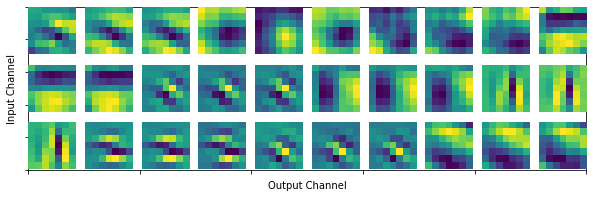

In [6]:
visualize_cnn(tl_model.ResNet.conv1)

### GradCAM

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

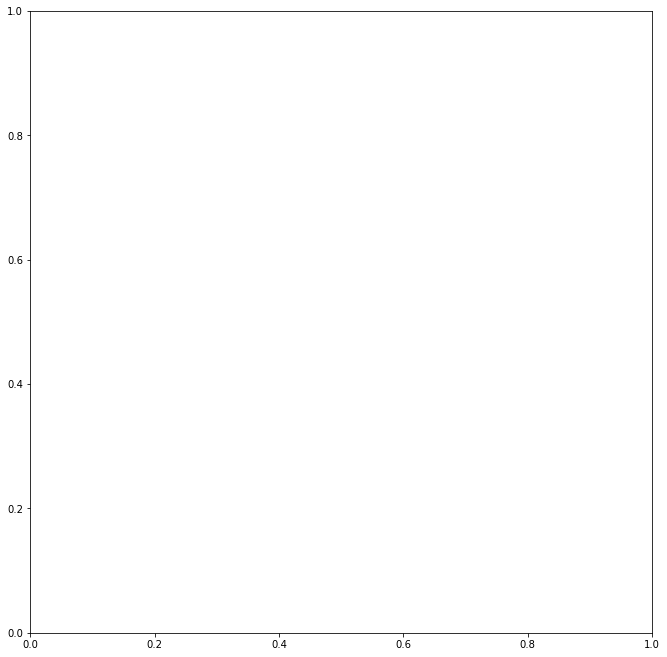

In [21]:
# UD.Ud...
udacity_dataset = UD.UdacityDataset(csv_file=csv_file_path, 
                                 root_dir=train_root,
                                 transform=transforms.Compose([transforms.ToTensor()]),
                                 select_camera=camera_type)


# Load arbitrary data
# Needs debugging seeing: TypeError: can't convert cuda:0 device type tensor to numpy. 
# Use Tensor.cpu() to copy the tensor to host memory first.
sample = udacity_dataset[3693]
sample['image'] = torch.unsqueeze(sample['image'].cuda(), 0)
#import pdb; pdb.set_trace()
pred_angle = tl_model(sample['image']) # pass sample through network to get predicted angle
show_sample(sample, pred_angle) # added second arg to run
input_image = sample['image'].reshape(-1, 3, 480, 640).cuda()


cam_extractor_tl = CamExtractorTLModel(tl_model)

# Forward pass
model_output = tl_model(input_image)

# Backward pass
tl_model.zero_grad()
mse_loss = nn.MSELoss()
loss = mse_loss(model_output, sample['angle'].cuda().reshape(1,1))
loss.backward()

cam_image = cam_extractor_tl.to_image(height=480, width=640) # Use this line to extract CAM image from the model!
plt.imshow(cam_image[0, :, :], cmap='jet', alpha=0.5) # this shows CAM as overlay to the original input image
